In [166]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(1024)
environ['n_epochs']= '500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '700 500 500 400 280'
environ['dropouts'] = '0.0 '*5
environ['log'] = 'True'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [167]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [168]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


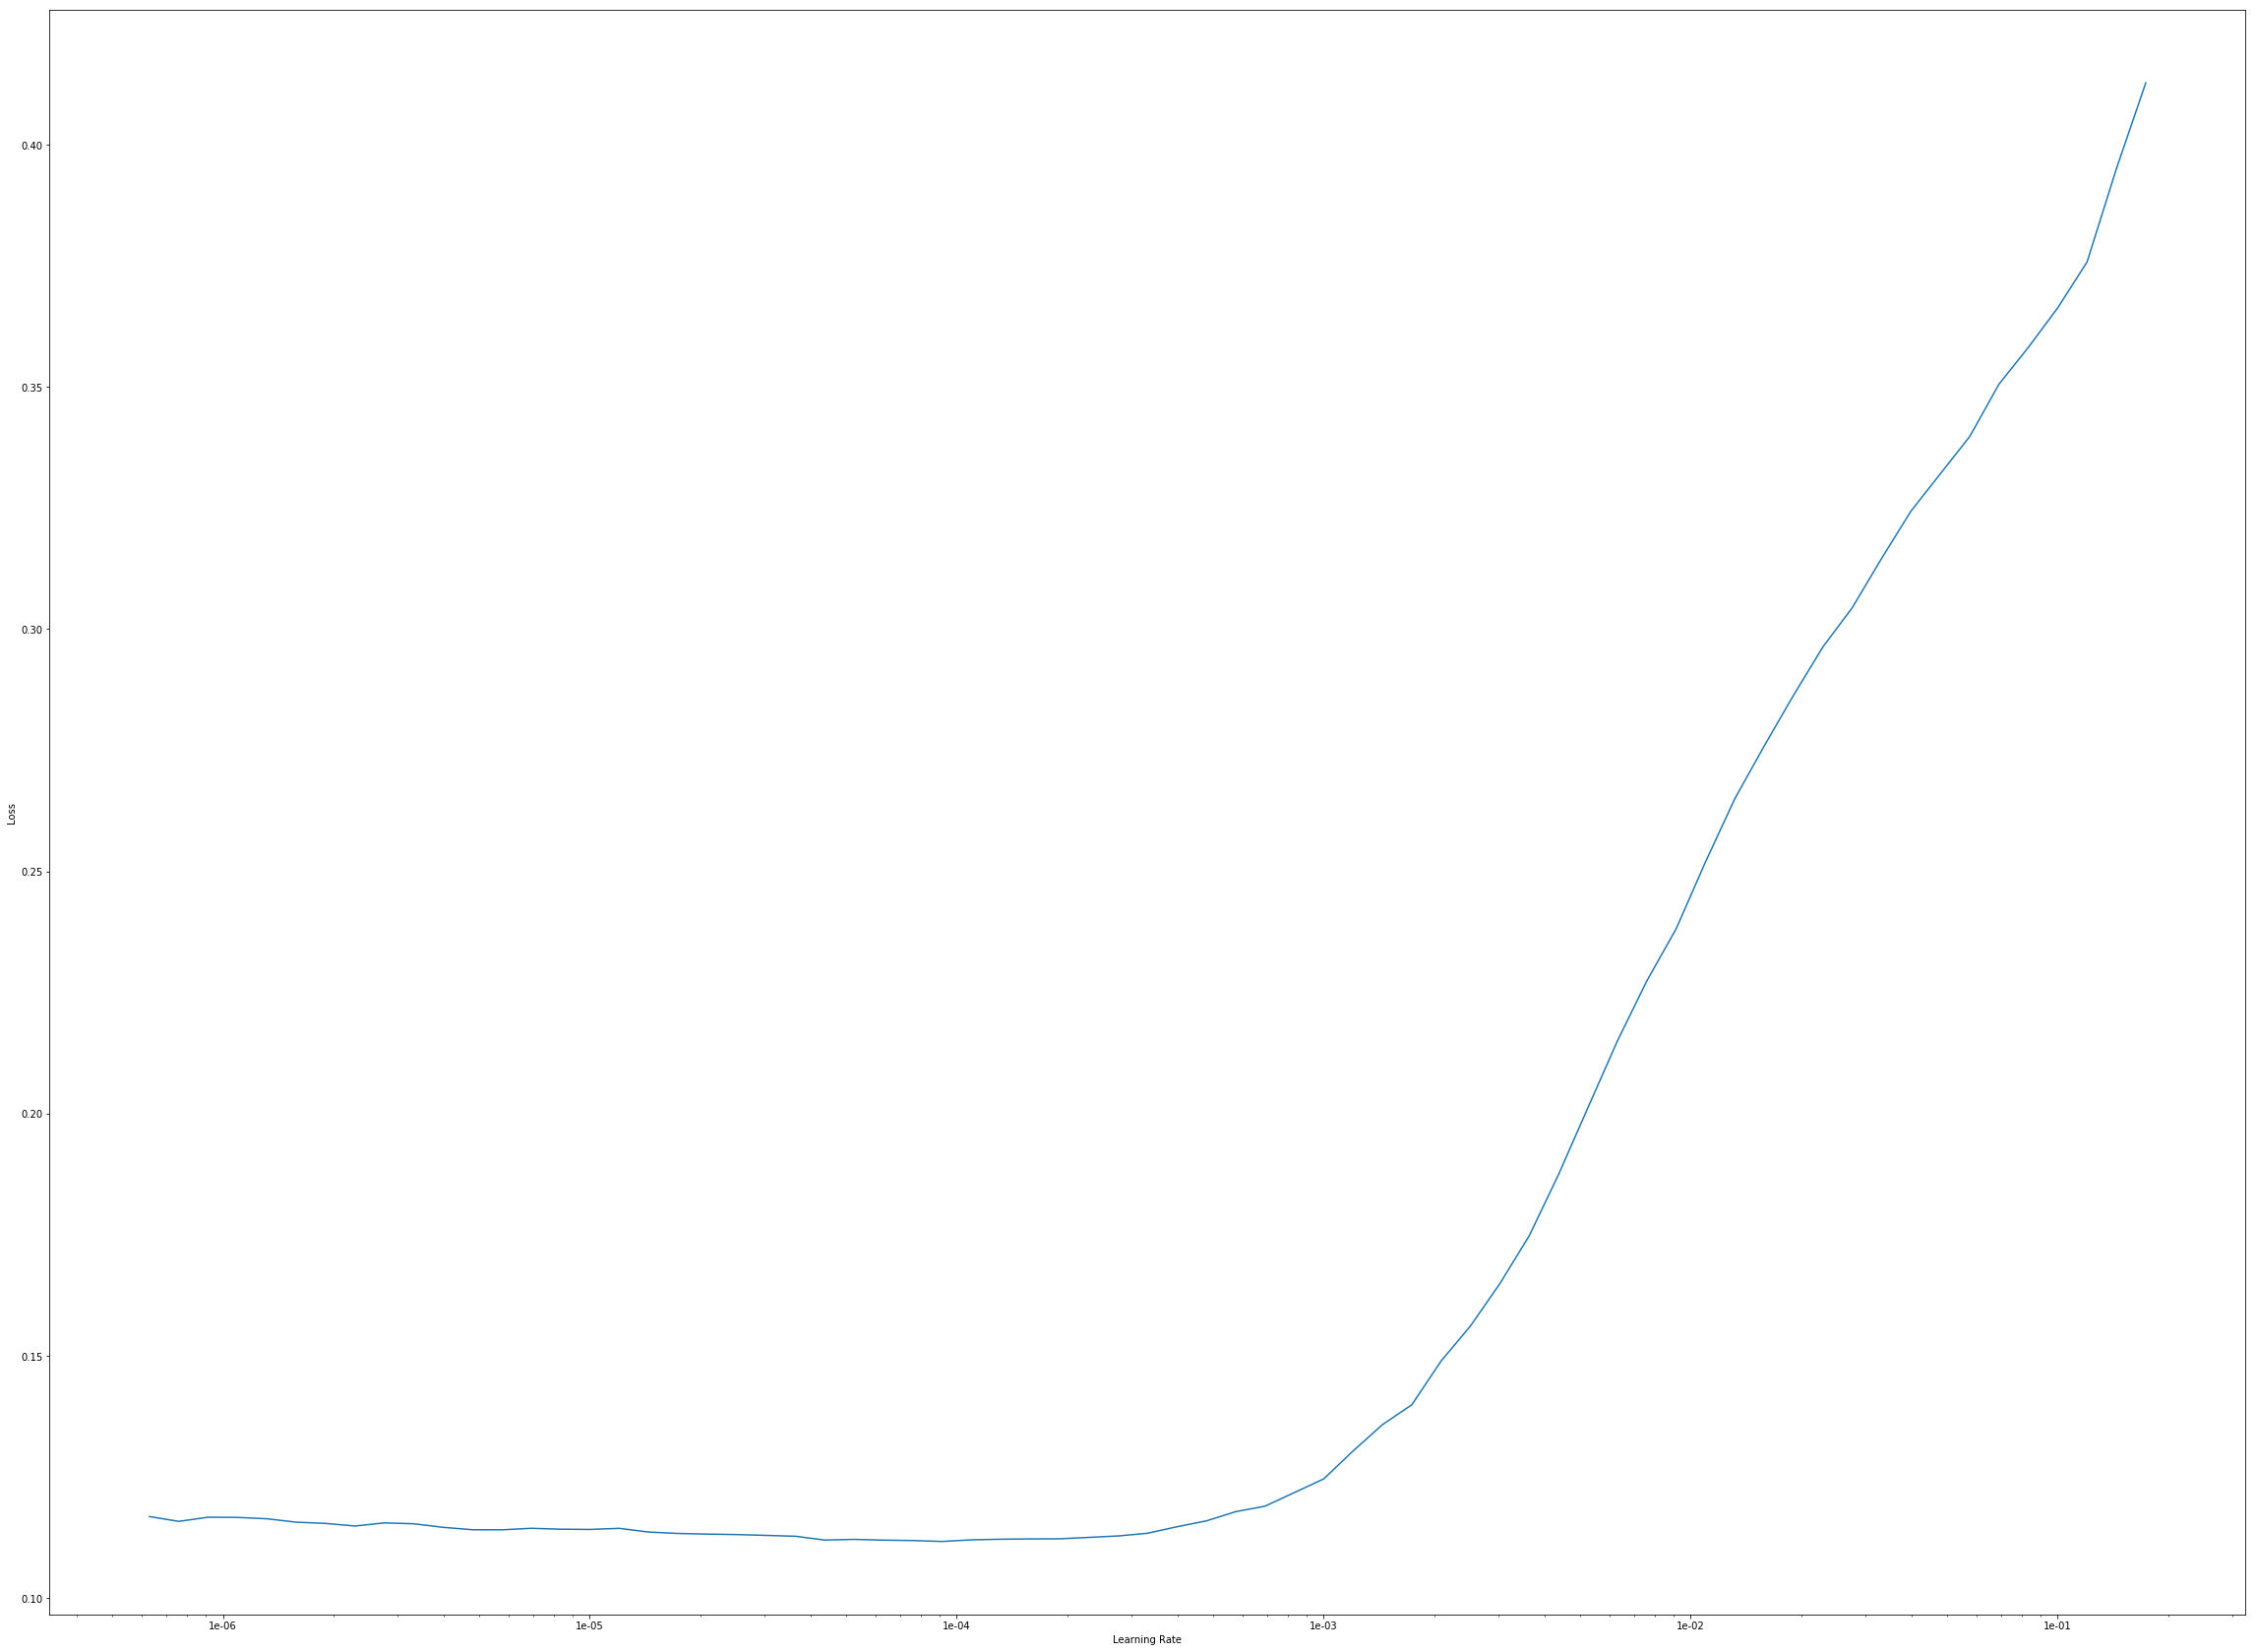

In [169]:
l.recorder.plot()

In [173]:
lr = 1e-5

In [174]:
l.fit_one_cycle(100, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,0.093961,0.173716,22.154509,0.416726
2,0.096026,0.156538,21.865612,0.395525
3,0.095646,0.166536,20.753847,0.407962
4,0.095121,0.153451,20.581888,0.391609
5,0.095224,0.171039,23.211643,0.413442
6,0.094929,0.146893,22.008413,0.383109
7,0.093233,0.159708,22.563532,0.399547
8,0.094252,0.146766,20.250841,0.383041
9,0.094860,0.173651,22.647129,0.416477
10,0.094299,0.145238,19.266603,0.380971


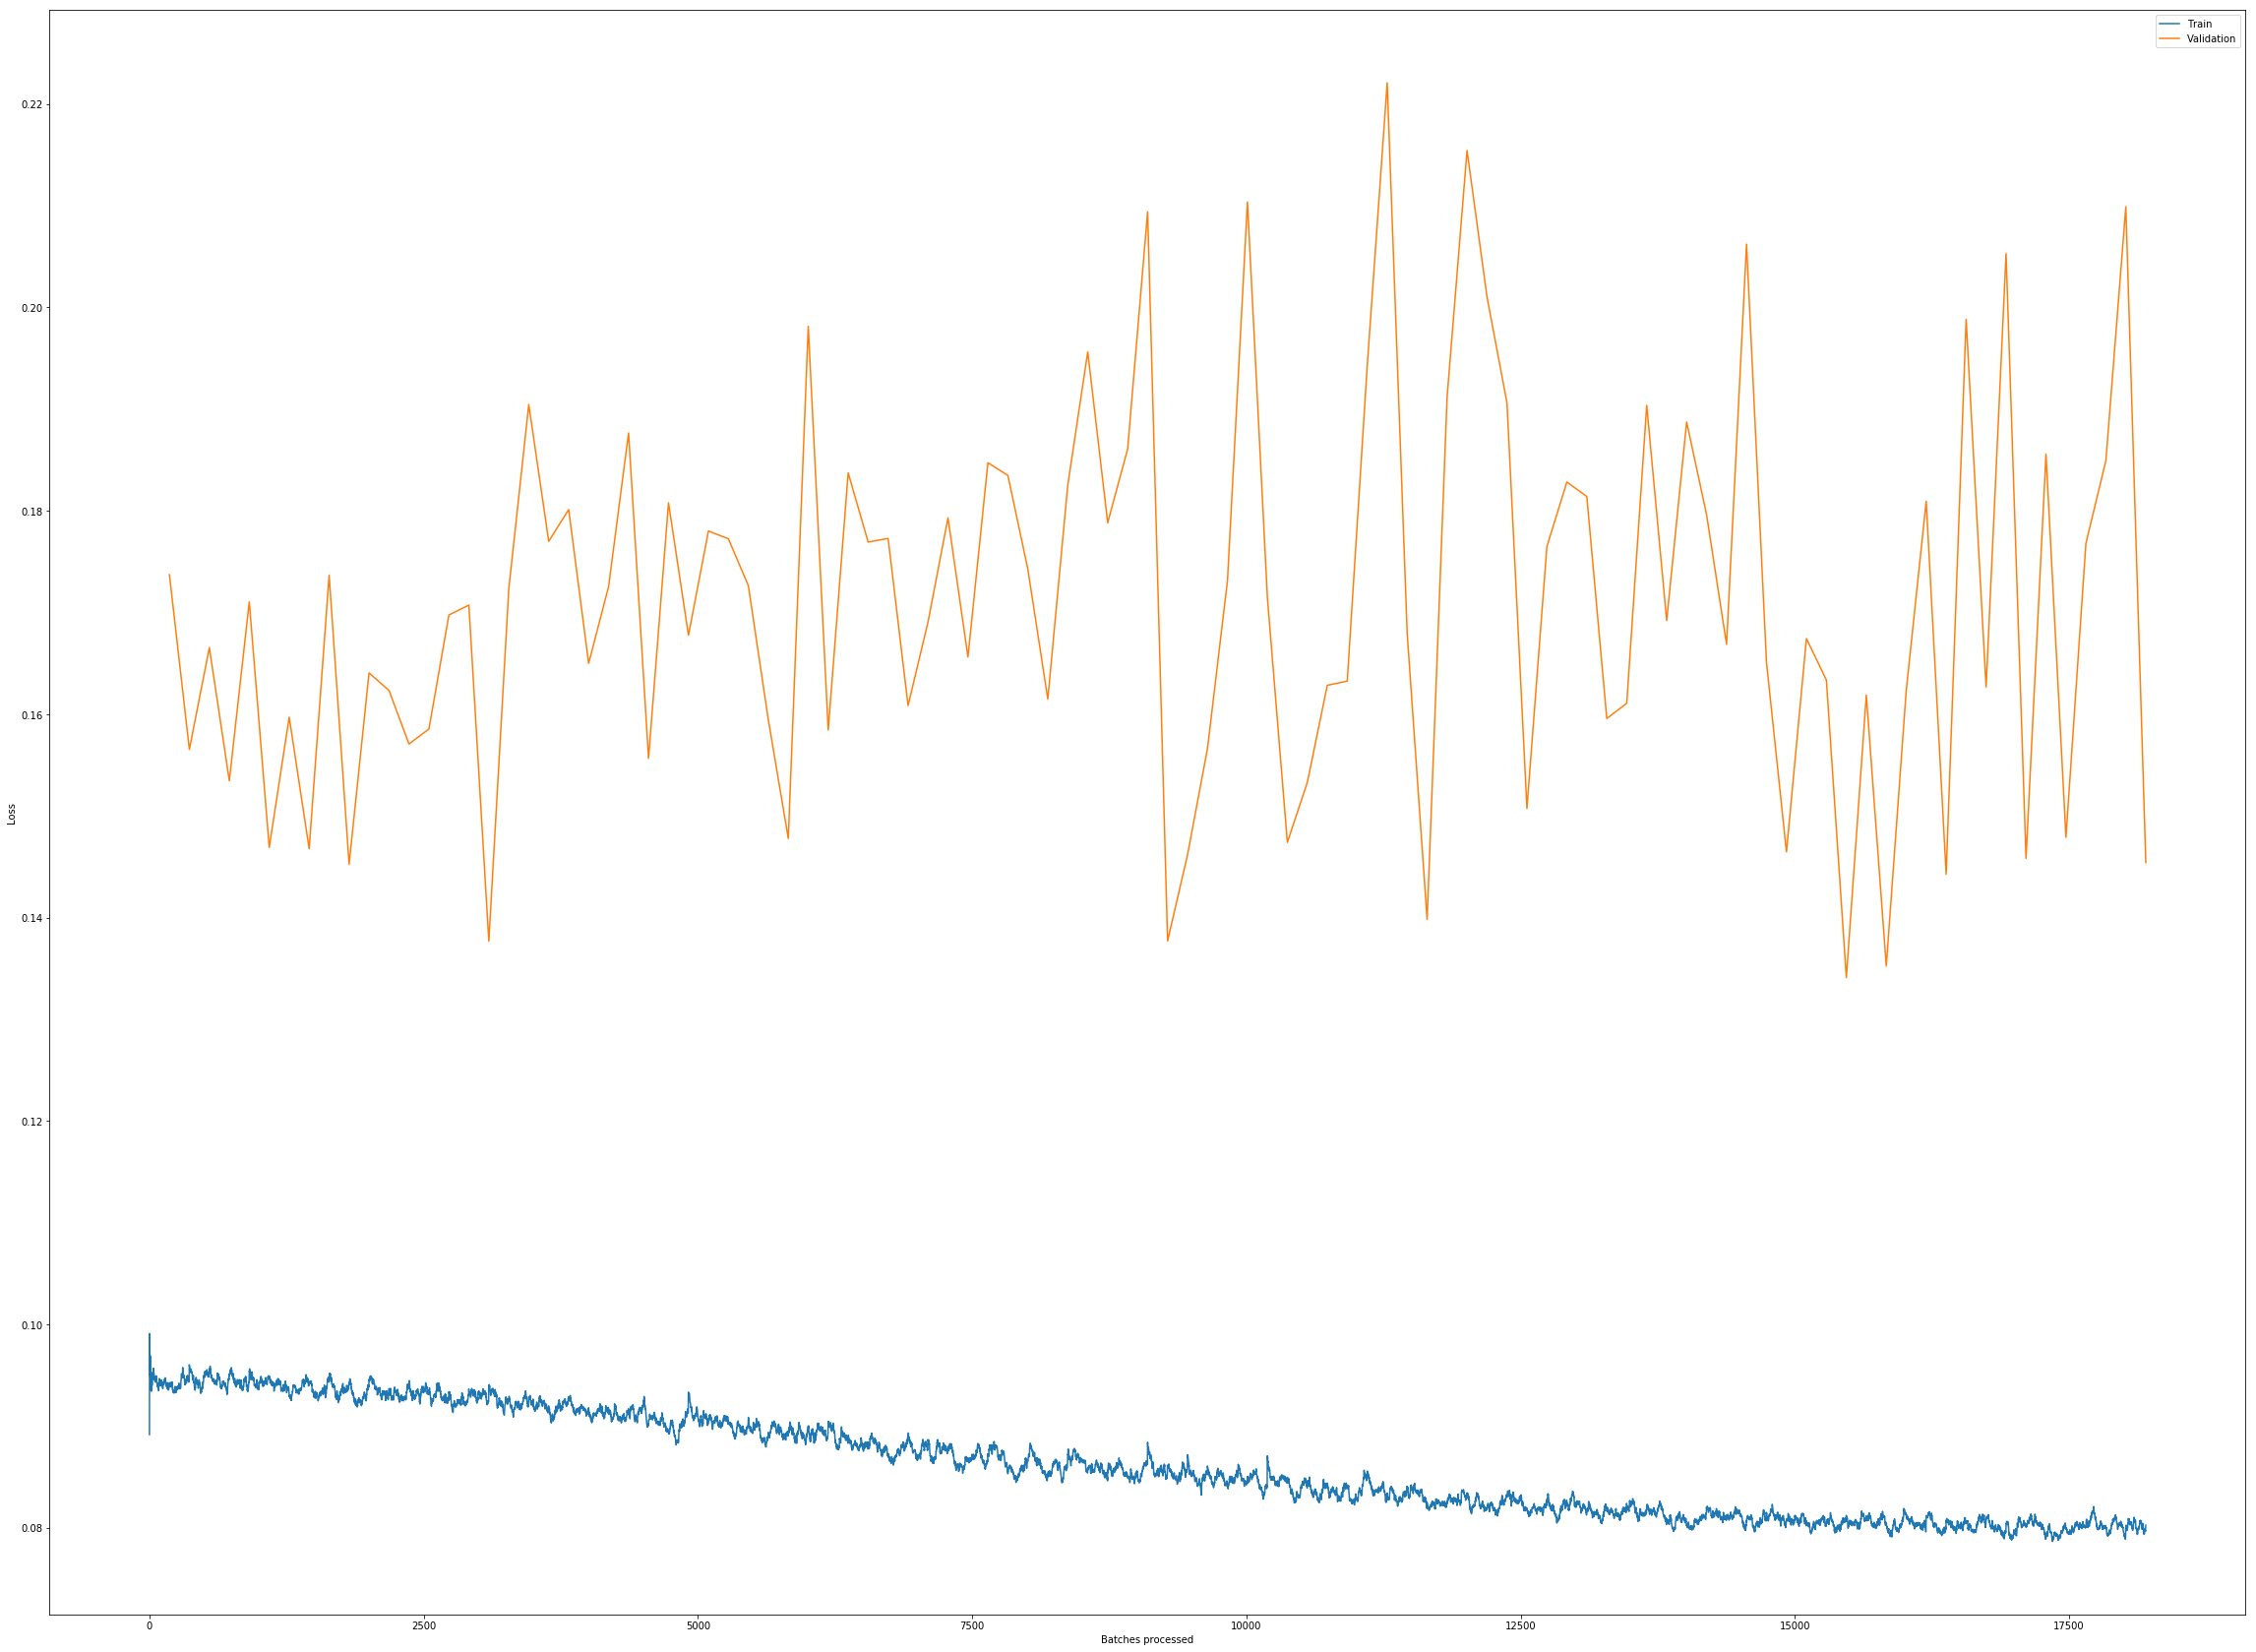

In [175]:
l.recorder.plot_losses()

In [151]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [176]:
val_df = get_results_df(val_dl, l.model, log=log)
train_df = get_results_df(train_dl, l.model, log=log)

In [179]:
df = val_df

In [180]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.775849,1.601825,0.576601,47.889462
std,1.836875,1.653595,0.744318,61.337360
min,0.011542,0.010685,0.000015,0.002017
25%,0.356929,0.301894,0.061631,12.369291
50%,1.162155,0.970127,0.267160,29.935443
75%,2.383443,2.176448,0.798659,60.516363
max,7.874421,7.522551,5.524107,724.534485


In [156]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,185651.000000,185651.000000
mean,1.084814,1.184810,0.324954,40.820557
std,1.344096,1.613917,0.569854,58.587891
min,0.013156,0.008491,0.000002,0.000193
25%,0.240377,0.211613,0.042083,10.870382
50%,0.544192,0.565550,0.132497,24.538118
75%,1.470753,1.394052,0.346775,46.853222
max,7.660851,16.089287,15.755830,2158.676758


In [23]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,657.000000,657.000000,657.000000,657.000000
mean,3.948848,5.115778,1.365126,29.287535
std,1.486039,2.790569,1.714994,38.937504
min,0.398863,0.105179,0.003013,0.206864
25%,2.479949,2.706949,0.270402,8.261179
50%,4.648192,5.420588,0.649103,21.397005
75%,4.834735,6.326712,1.784681,33.637047
max,5.690990,12.500638,7.442226,280.300598


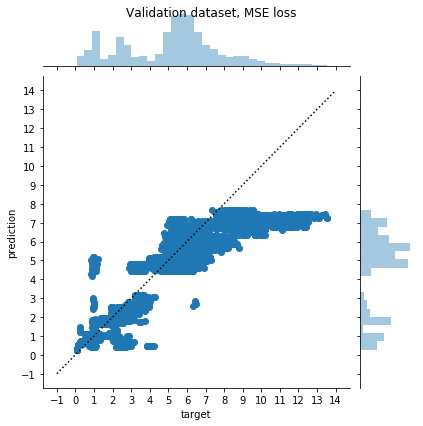

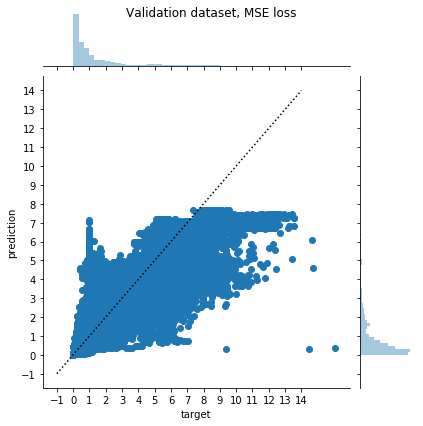

In [155]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")